In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download --unzip lantian773030/pokemonclassification

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import numpy as np
import time

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 406M/417M [00:05<00:00, 103MB/s] 
100% 417M/417M [00:05<00:00, 82.2MB/s]


In [ ]:
def get_model_name(path="/content/drive/My Drive/project/alexnet_with_decay", batch_size=64, learning_rate=0.01, epoch=30):
    path = "{}/poke7k_bs{}_lr{}_epoch{}".format(path,
            batch_size, learning_rate, epoch)
    return path

def get_data_loader(batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.Resize((224,224)), 
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load training data
    features_path = '/content/drive/My Drive/alexnet_with_decay_features'                                          #Alexnet
    alexnet_data = torchvision.datasets.DatasetFolder(features_path, loader=torch.load, extensions=('.tensor'))    #alexnet

    # Get the list of indices to sample from
    relevant_indices = []
    for i in range(len(alexnet_data)): relevant_indices.append(i)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.9) #split at 90%
    split1 = int(len(relevant_indices) * 0.99) #split at 99%
    
    # split into training, validation and testing indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split], relevant_indices[split:split1], relevant_indices[split1:]  
  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(alexnet_data, batch_size=batch_size,
                                              num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(alexnet_data, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(alexnet_data, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader

In [ ]:
import torchvision.models
import os
alexnet = torchvision.models.alexnet(pretrained=True)

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = 'PokemonData/'
alexnet_data = datasets.ImageFolder(train_path,transform)

classes = []
for root, dirs, files in os.walk("PokemonData"):
    for dir in dirs:
        classes.append(dir)
classes.sort()

alexnet_data = torch.utils.data.DataLoader(alexnet_data, batch_size=1, num_workers=1, shuffle=False)
features_path = '/content/drive/My Drive/alexnet_with_decay_features'

n=0

for img, label in alexnet_data:
    feature = alexnet.features(img)
    feature = torch.from_numpy(feature.detach().numpy())

    dir = features_path + '/' + str(classes[label])
    if not os.path.isdir(dir):
      os.mkdir(dir)

    torch.save(feature.squeeze(0), dir + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(20)
for i, data in enumerate(train_loader, 0):
  imgs,labels = data
  print(i,imgs.shape,labels)
  if i==3: break

for i, data in enumerate(val_loader, 0):
  imgs,labels = data
  print(i,imgs.shape,labels)
  if i==3: break

for i, data in enumerate(test_loader, 0):
  imgs,labels = data
  print(i,imgs.shape,labels)
  if i==3: break  

0 torch.Size([20, 256, 6, 6]) tensor([122,  55,  36,   3,  93,  93,  19,  26,  57, 115,  78,  23,  96,   0,
         73,  77, 144,  84,  96, 119])
1 torch.Size([20, 256, 6, 6]) tensor([ 26, 139,  34, 146,  78, 124, 117, 141, 115,  53,  38, 128, 101,  49,
        133,  42,  82,  99,   3,  76])
2 torch.Size([20, 256, 6, 6]) tensor([116,  21,  80,  22, 105,  46,  62,  29, 108, 131, 127, 125,  39,  59,
         21,  57, 104,  74,  74, 132])
3 torch.Size([20, 256, 6, 6]) tensor([111,  26,  77,   0,  30,  39,   7, 147, 107,  65,  45,  87,  72,   1,
        101, 143, 100,  71, 106, 126])
0 torch.Size([20, 256, 6, 6]) tensor([ 92,  40,  33, 138, 106, 107,  26,  89, 132,  31,   8,  81,  30,  45,
         62,  84, 147,  10,  51, 143])
1 torch.Size([20, 256, 6, 6]) tensor([ 34, 120,  27, 111,  25, 123,  42,  65,  42, 132,   1, 142,  94, 101,
         73,  51,  74,   2, 117,   8])
2 torch.Size([20, 256, 6, 6]) tensor([ 18,  54, 139, 118,  24, 132,   1,  33,  94,  13,  82,  64,  43,  54,
         9

In [ ]:
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.name = "AlexNet"
        self.fc1 = nn.Linear(256 * 6 * 6, 450)
        self.fc2 = nn.Linear(450, 150)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:
        
    #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
           imgs = imgs.cuda()
           labels = labels.cuda()
    #############################################

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_loader, val_loader, batch_size=64, num_epochs=1, learning_rate=0.01, save_data_path="", weight_decay=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []
    bss, lrs, times = [], [], []

    # training
    n = 0 # the number of iterations
    start_epoch = 0 
    end_epoch = num_epochs

    if save_data_path != "":
      save_data = torch.load(save_data_path)
      start_epoch = save_data["epoch"]+1
      end_epoch = start_epoch + num_epochs
      iters = save_data["iters"]
      n = iters[-1]+1
      print("n = {}".format(n))
      losses = save_data["losses"]
      train_acc = save_data["train_acc"]
      val_acc = save_data["val_acc"]
      model.load_state_dict(save_data["state"])
      bss = save_data["bss"]
      lrs = save_data["lrs"]
      times = save_data["times"]

    start_time = last_time = time.time()    

    for epoch in range(start_epoch, end_epoch):
        for imgs, labels in iter(train_loader):
              
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))   # compute validation accuracy
            
            n += 1
        
        bss.append(batch_size)                            
        lrs.append(learning_rate)     
        times.append(time.time()-last_time)      
        last_time=time.time() 
        model_path = get_model_name(epoch=epoch+1,batch_size=batch_size,learning_rate=learning_rate)
        save_data = {"epoch":epoch,
                        "iters":iters,
                        "losses":losses,
                        "train_acc":train_acc,
                        "val_acc":val_acc,
                        "times":time.time()-start_time,
                        "state":model.state_dict(),
                        "bss":bss,
                        "lrs":lrs,
                        "times":times}
        torch.save(save_data, model_path)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f; Time %f;" % (epoch+1, loss, train_acc[-1], val_acc[-1], sum(times)))

    end_time = time.time()
    elapsed_time = end_time - start_time

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time elapsed: {:.2f} seconds".format(sum(times)))

In [ ]:
def get_saved_data_info(saved_data_path,item = "all"):
  if saved_data_path != "":
      save_data = torch.load(saved_data_path)
      if item != "all":
        print(item+" is "+save_data[item])
        return
      for item in save_data:
        if item != "state": print(item+"\n",save_data[item])

In [ ]:
def featursDataLoaders(train_loader,val_loader,test_loader):
  !mkdir ./dataset/features
  !rm -rf ./dataset/features/*
  # i=0
  train_features, val_features, test_features = [],[],[]
  
  for i,data in enumerate(train_loader,0):
    imgs, labels = data
    torch.save((alexnet.features(imgs)).detach().numpy(),"./dataset/features/train_features_{}".format(i))
  
  for i,data in enumerate(val_loader,0):
    imgs, labels = data
    torch.save((alexnet.features(imgs)).detach().numpy(),"./dataset/features/val_features_{}".format(i))

  for i,data in enumerate(test_loader,0):
    imgs, labels = data
    torch.save((alexnet.features(imgs)).detach().numpy(),"./dataset/features/test_features_{}".format(i))


CUDA is not available.  Training on CPU ...
Epoch 1; Loss 4.715331; Train Acc 0.173346; Val Acc 0.114192; Time 116.567130;
Epoch 2; Loss 3.636813; Train Acc 0.478332; Val Acc 0.334421; Time 243.068998;
Epoch 3; Loss 2.505852; Train Acc 0.749593; Val Acc 0.634584; Time 385.504394;
Epoch 4; Loss 1.566270; Train Acc 0.851580; Val Acc 0.722675; Time 517.998713;
Epoch 5; Loss 0.921846; Train Acc 0.904366; Val Acc 0.779772; Time 654.819345;
Epoch 6; Loss 0.699153; Train Acc 0.936787; Val Acc 0.831974; Time 773.405389;
Epoch 7; Loss 0.566502; Train Acc 0.957478; Val Acc 0.825449; Time 891.038587;
Epoch 8; Loss 0.426828; Train Acc 0.969371; Val Acc 0.833605; Time 1009.413494;
Epoch 9; Loss 0.321553; Train Acc 0.976377; Val Acc 0.853181; Time 1121.440196;
Epoch 10; Loss 0.243195; Train Acc 0.985337; Val Acc 0.856444; Time 1238.261726;
Epoch 11; Loss 0.257268; Train Acc 0.987292; Val Acc 0.869494; Time 1349.303993;
Epoch 12; Loss 0.205259; Train Acc 0.992506; Val Acc 0.871126; Time 1472.038861;


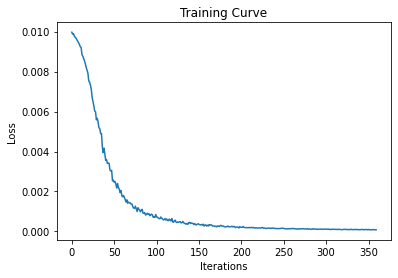

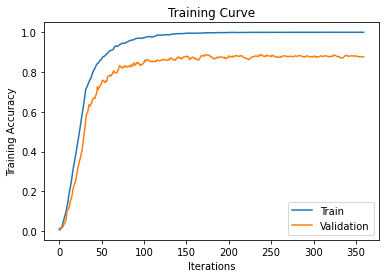

Final Training Accuracy: 0.9991854024112089
Final Validation Accuracy: 0.8760195758564437
Total time elapsed: 3669.30 seconds


In [ ]:
#Alexnet 512
use_cuda = True

model = AlexClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train_loader, val_loader, test_loader = get_data_loader(512)
train(model, train_loader, val_loader, batch_size=512, learning_rate = 0.005, num_epochs=30, weight_decay=0.001)

CUDA is not available.  Training on CPU ...
Epoch 1; Loss 3.974197; Train Acc 0.431085; Val Acc 0.308320; Time 255.335816;
Epoch 2; Loss 1.962579; Train Acc 0.780547; Val Acc 0.634584; Time 496.640925;
Epoch 3; Loss 0.805164; Train Acc 0.918540; Val Acc 0.787928; Time 727.979902;
Epoch 4; Loss 0.491094; Train Acc 0.958781; Val Acc 0.814029; Time 952.350388;
Epoch 5; Loss 0.396048; Train Acc 0.977680; Val Acc 0.845024; Time 1179.487929;
Epoch 6; Loss 0.223025; Train Acc 0.988596; Val Acc 0.862969; Time 1411.729262;
Epoch 7; Loss 0.169525; Train Acc 0.994787; Val Acc 0.849918; Time 1646.801942;
Epoch 8; Loss 0.119338; Train Acc 0.996253; Val Acc 0.854812; Time 1885.261312;
Epoch 9; Loss 0.117245; Train Acc 0.997067; Val Acc 0.861338; Time 2126.820733;
Epoch 10; Loss 0.079176; Train Acc 0.998371; Val Acc 0.866232; Time 2364.309333;
Epoch 11; Loss 0.062115; Train Acc 0.998697; Val Acc 0.876020; Time 2590.370096;
Epoch 12; Loss 0.077258; Train Acc 0.998697; Val Acc 0.876020; Time 2825.31280

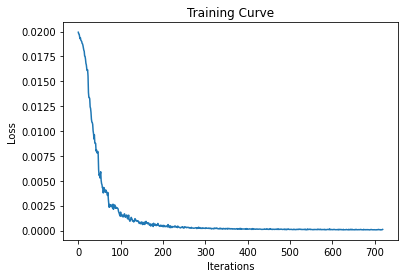

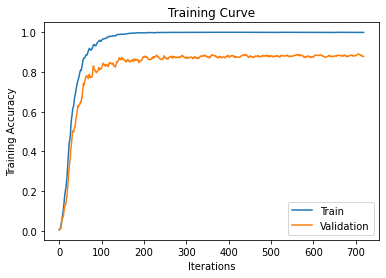

Final Training Accuracy: 0.998533724340176
Final Validation Accuracy: 0.8776508972267537
Total time elapsed: 7181.26 seconds


In [ ]:
#Alexnet 256
use_cuda = True

model = AlexClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train_loader, val_loader, test_loader = get_data_loader(256)
train(model, train_loader, val_loader, batch_size=256, learning_rate = 0.005, num_epochs=30, weight_decay=0.001)

In [ ]:
#read file from paused location
model_path = get_model_name(batch_size=512, learning_rate=0.005, epoch=17)
get_saved_data_info(model_path)

In [ ]:
#Alexnet start from pause
use_cuda = True

model = AlexClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
model_path = get_model_name(batch_size=512, epoch=23, learning_rate=0.005)
train_loader, val_loader, test_loader = get_data_loader(512)
train(model, train_loader, val_loader, batch_size=512, num_epochs=7, learning_rate=0.005, save_data_path=model_path, weight_decay=0.001)